In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.constants import L_v, c_p,g,R
from isca_tools.utils.moist_physics import saturation_vapor_pressure, clausius_clapeyron_factor, sphum_sat, \
    sphum_from_dew, moist_static_energy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%time
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5

CPU times: user 33 µs, sys: 1e+03 ns, total: 34 µs
Wall time: 34.1 µs


In [3]:
def time_to_year(ds):
    ds = ds.assign_coords(year=ds['time'].dt.year)  # Add a 'year' coordinate
    ds = ds.swap_dims({'time': 'year'})             # Replace 'time' as dimension with 'year'
    ds = ds.drop_vars('time')                       # Optionally remove 'time' variable
    return ds

## Sanity Check that my data is similar to Zhang and Boos
Below we see that except for 2021 for `t2m`, and 1999 and 2021 for `t500` the values I got from ERA5 and that used by Zhang in the 2023 paper are very similar.

I guess the 2021 data may have been updated since Zhang did their analysis. For 1999, it seems there are some land areas around the tropics which are larger in my data compared to Zhang. But it seems that my plot of `t500_of_t2m_max` is much better than the Zhang plot.

In [4]:
t2m_av_use = 'max'     # get variables conditioned on annual maximum of daily max or mean temperature
if t2m_av_use != 'max':
    print('WARNING: Zhang 2023 used daily maximum 2m temperature')
# Should only match zhang and boos if 'max' used

In [5]:
t2m_max_zhang = time_to_year(xr.open_dataset('./Code_Zhang_Boos/TXx_1979-2021.nc')).TXx
t2m_max = xr.open_dataset(f'./processed/daily_{t2m_av_use}/t2m_max.nc').t2m

In [6]:
t500_zhang = time_to_year(xr.open_dataset('./Code_Zhang_Boos/t500ofTXx_1979-2021.nc')).t500
t500 = xr.open_dataset(f'./processed/daily_{t2m_av_use}/t500_of_t2m_max.nc').isel(pressure_level=0, drop=True).t500
t500 = t500.drop('number')

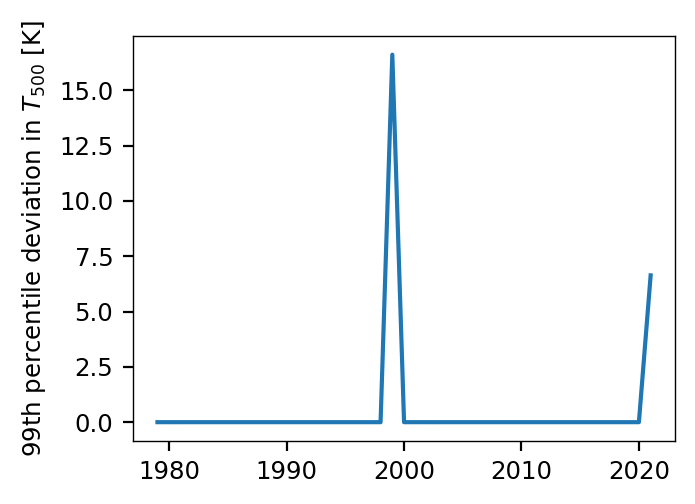

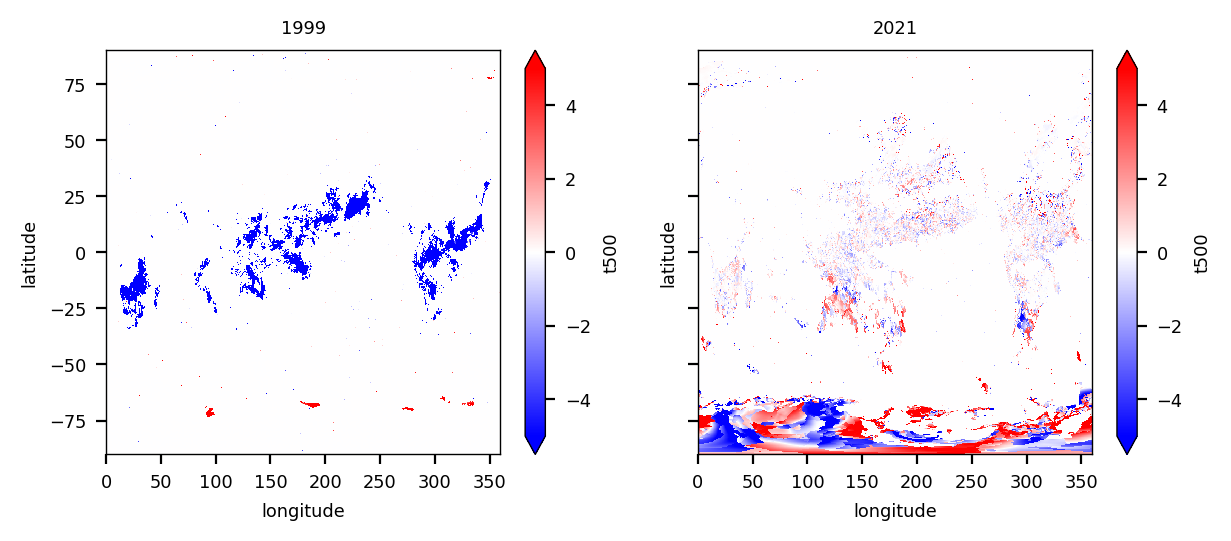

In [7]:
var_plot = 't500'
if var_plot == 't2m':
    var_diff = (t2m_max_zhang - t2m_max)
else:
    var_diff = (t500_zhang - t500)
var_diff_abs_max = np.abs(var_diff).quantile(0.99, dim=['longitude', 'latitude'])
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3.5)
ax.plot(var_diff.year, var_diff_abs_max)
ax.set_ylabel(f'99th percentile deviation in $T_{"{2m}" if var_plot=="t2m" else "{500}"}$ [K]')
update_fontsize(fig)

# Plot years with large deviation
years_plot = var_diff_abs_max > 1
n_plot = int(sum(years_plot))
if n_plot > 3:
    n_plot = 3
fig, ax = plt.subplots(1, n_plot, sharex=True, sharey=True)
if n_plot == 1:
    ax = [ax]
fig_resize(fig, 3.5*n_plot)
for i, year in enumerate(var_diff.year[years_plot]):
    var_diff.sel(year=year).plot(ax=ax[i], vmin=-5, vmax=5, cmap='bwr')
    ax[i].set_title(int(year))
    if i >= n_plot - 1:
        break

update_fontsize(fig)
plt.show()

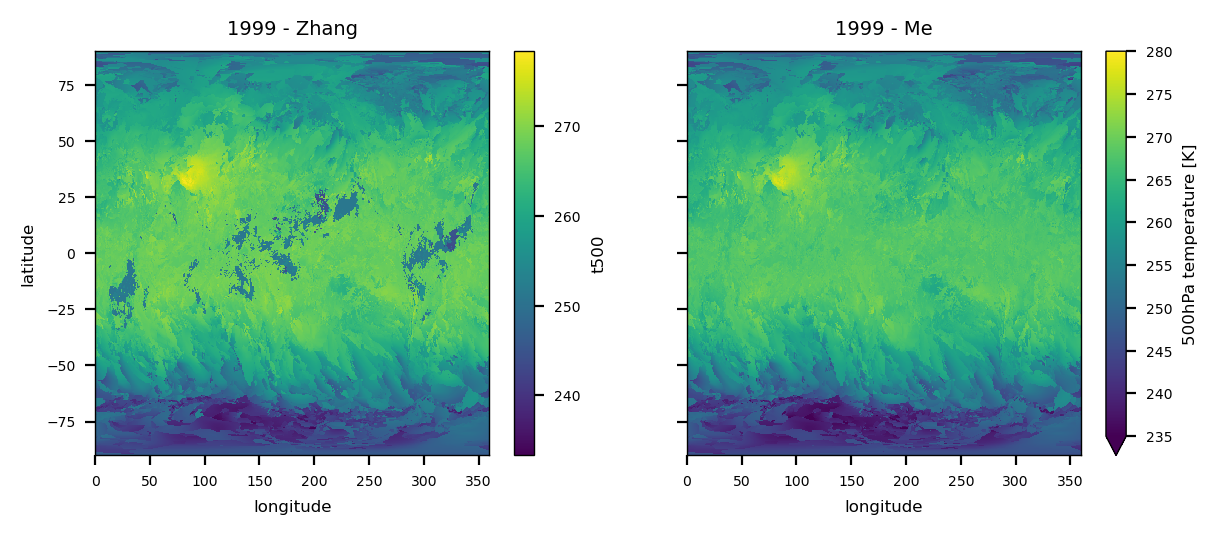

In [8]:
year = 1999
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 3.5*2)
t500_zhang.sel(year=year).plot(ax=ax[0])
t500.sel(year=year).plot(ax=ax[1], vmin=235, vmax=280)
ax[1].set_ylabel('')
ax[0].set_title(f'{year} - Zhang')
ax[1].set_title(f'{year} - Me')
plt.show()

In [9]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
lsm_zhang = xr.open_dataset('./Code_Zhang_Boos/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc').LSM.squeeze()
lsm = xr.open_dataset('../invariants/lsm1979.nc').lsm.squeeze()
# lsm = lsm_zhang
land = lsm.where(lsm>0.5)*0+1
ocean = lsm.where(lsm<=0.5)*0+1
weights = np.cos(np.deg2rad(land.latitude))

In [10]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3.5)
(lsm_zhang - lsm).plot(vmin=-0.1, vmax=0.1, cmap='bwr', ax=ax)
update_fontsize(fig)
# plt.show()
plt.close()

### Figure 4 of Zhang & Boos
Below, I recreate the Zhang & Boos Fig 4 with the data that I have downloaded, basically as a sanity check that I get the same results.

In [53]:
# Mean 500-hPa values between 40N-65N over land during 1979-2021
z500_mean = 55.74162890625 * 1000 / g   # 5 km x 9.81 would be 55 so the zhang value of 55 must be in units of km multiplied by g. So convert to m
t500_mean = 258.82523

years = t500.year.to_numpy()

lat_min = 40
lat_max = 65

(245.0, 280.0)

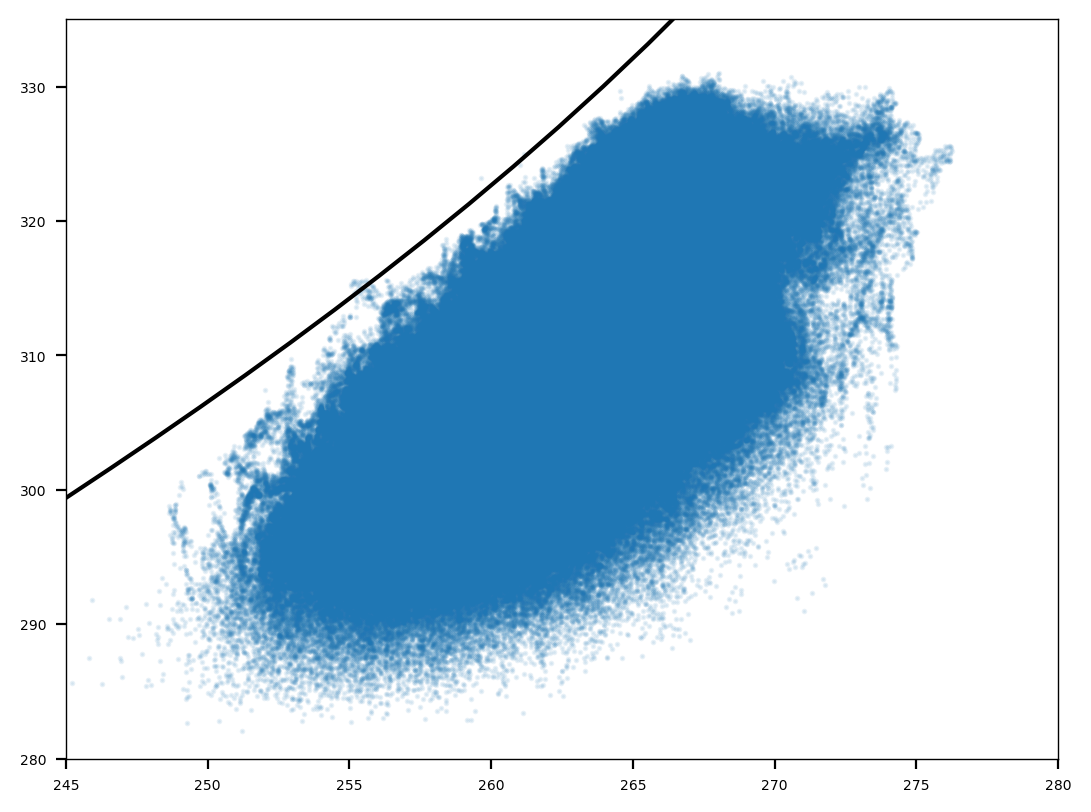

In [63]:
# Sanity check that upper bound eqn works
def zhang_upper_bound(t500):
    return t500 + L_v/c_p * sphum_sat(t500, 500*100) + g/c_p * z500_mean/t500_mean * t500

plt.scatter((t500.sel(latitude=slice(65, 40))) * land, ((t2m_max + g/c_p * z2m).sel(latitude=slice(65, 40))) * land, s=1, alpha=0.1)
plt.plot(np.linspace(245, 275, 20), zhang_upper_bound(np.linspace(245, 275, 20)), color='k')
plt.ylim(280, 335)
plt.xlim(245, 280)

In [18]:
def xr_linregress(x, y, dim="time"):
    # align the nan Values before...
    x = x.where(~np.isnan(y))
    y = y.where(~np.isnan(x))
    n = y.notnull().sum(dim)

    nanmask = np.isnan(y).all(dim)

    xmean = x.mean(dim)
    ymean = y.mean(dim)
    xstd = x.std(dim)
    ystd = y.std(dim)

    cov = ((x - xmean) * (y - ymean)).sum(dim) / (n)
    cor = cov / (xstd * ystd)

    slope = cov / (xstd ** 2)
    intercept = ymean - xmean * slope

    df = n - 2
    TINY = 1.0e-20
    tstats = cor * np.sqrt(df / ((1.0 - cor + TINY) * (1.0 + cor + TINY)))
    stderr = slope / tstats

    pval = (
        xr.apply_ufunc(
            sts.distributions.t.sf,
            abs(tstats),
            df,
            dask="parallelized",
            output_dtypes=[y.dtype],
        )
        * 2
    )

    return xr.Dataset(
        {
            "slope": slope,
            "intercept": intercept,
            "r_value": cor.fillna(0).where(~nanmask),
            "p_value": pval,
            "std_err": stderr.where(~np.isinf(stderr), 0),
        }
    )

def ds_year_to_time(ds):
    if 'year' in ds.coords:
        year_start = int(ds.year[0])
        year_end = int(ds.year[-1])
        ds = ds.rename({'year': 'time'})
        ds = ds.assign_coords(time=pd.date_range(start=f'{year_start}-01-01', end=f'{year_end}-01-01', freq='AS'))
    return ds

def dT2m_dT500_theory(T500):
    # Prefactor to multiply by change in T_500 to get estimate of change in 2m temperature
    p500 = 500 * 100       # 500 hPa in Pa
    return 1 + L_v/c_p * clausius_clapeyron_factor(T500, p500) * sphum_sat(T500, p500)+z500_mean/t500_mean/c_p/g

def hatch_insignificant_regions(ax, p_values, lat=t2m_max.latitude, lon=t2m_max.longitude):
    # Hatch regions that did not pass significance test
    hypoth_rejected = fdrcorrection(p_values.to_numpy().flatten(), alpha=0.05)[0]
    hypoth_rejected = hypoth_rejected.reshape(lat.size, lon.size)
    data, lon_use = add_cyclic_point(np.where(np.isnan(p_values), np.nan, ~hypoth_rejected),
                                 coord=lon.values, axis=1)          # set where input is nan to nan
    ax.contourf(lon_use, lat.values, data, transform=ccrs.PlateCarree(), levels=[0.5, 1], hatches=['////', None], colors='none')

In [21]:
%%time
use_zhang_raw = False
# TXx from ERA5 reanlysis
TXx = t2m_max_zhang if use_zhang_raw else t2m_max
TXx = ds_year_to_time(TXx)
TXx_mean =  (TXx*land).sel(latitude=slice(lat_max,lat_min)).weighted(weights).mean(['latitude','longitude'])

# T500 on the annual hottest days from ERA5 reanalysis
t500_of_TXx = t500_zhang if use_zhang_raw else t500 # Refer to the other notebook for these data were generated
t500_of_TXx = ds_year_to_time(t500_of_TXx)
t500_of_TXx_mean = (t500_of_TXx*land).sel(latitude=slice(lat_max,lat_min)).weighted(weights).mean(['latitude','longitude'])
t500_trend = sts.linregress(years, t500_of_TXx_mean).slope
t500_trend_std = sts.linregress(years, t500_of_TXx_mean).stderr

# Calculated land-mean TXx trend from T500 trend
TXx_trend_proj = t500_trend*dT2m_dT500_theory(t500_of_TXx_mean.mean())
TXx_trend_proj_std = t500_trend_std*dT2m_dT500_theory(t500_of_TXx_mean.mean())

#
#
# # 2-D plots
time = xr.DataArray(data = years, coords={'time': TXx.time}, dims='time')
reg_TXx = xr_linregress(time.sel(time=slice(str(years[0]), str(years[-1]))),
                        (TXx*land).sel(time=slice(str(years[0]), str(years[-1])))).compute() # Linear trend of TXx for each location over land
reg_t500_of_TXx = xr_linregress(time.sel(time=slice(str(years[0]), str(years[-1]))),
                                (t500_of_TXx*land).sel(time=slice(str(years[0]), str(years[-1])))).compute() # T500 trend for each location over land
reg_TXx_proj = reg_t500_of_TXx*dT2m_dT500_theory(t500_of_TXx.mean('time')) # Calculated TXx trend from theory and T500 trend

CPU times: user 1.78 s, sys: 998 ms, total: 2.78 s
Wall time: 2.99 s


In [22]:
include_hatch = False # whether to include hatching for insignificant trends in figures

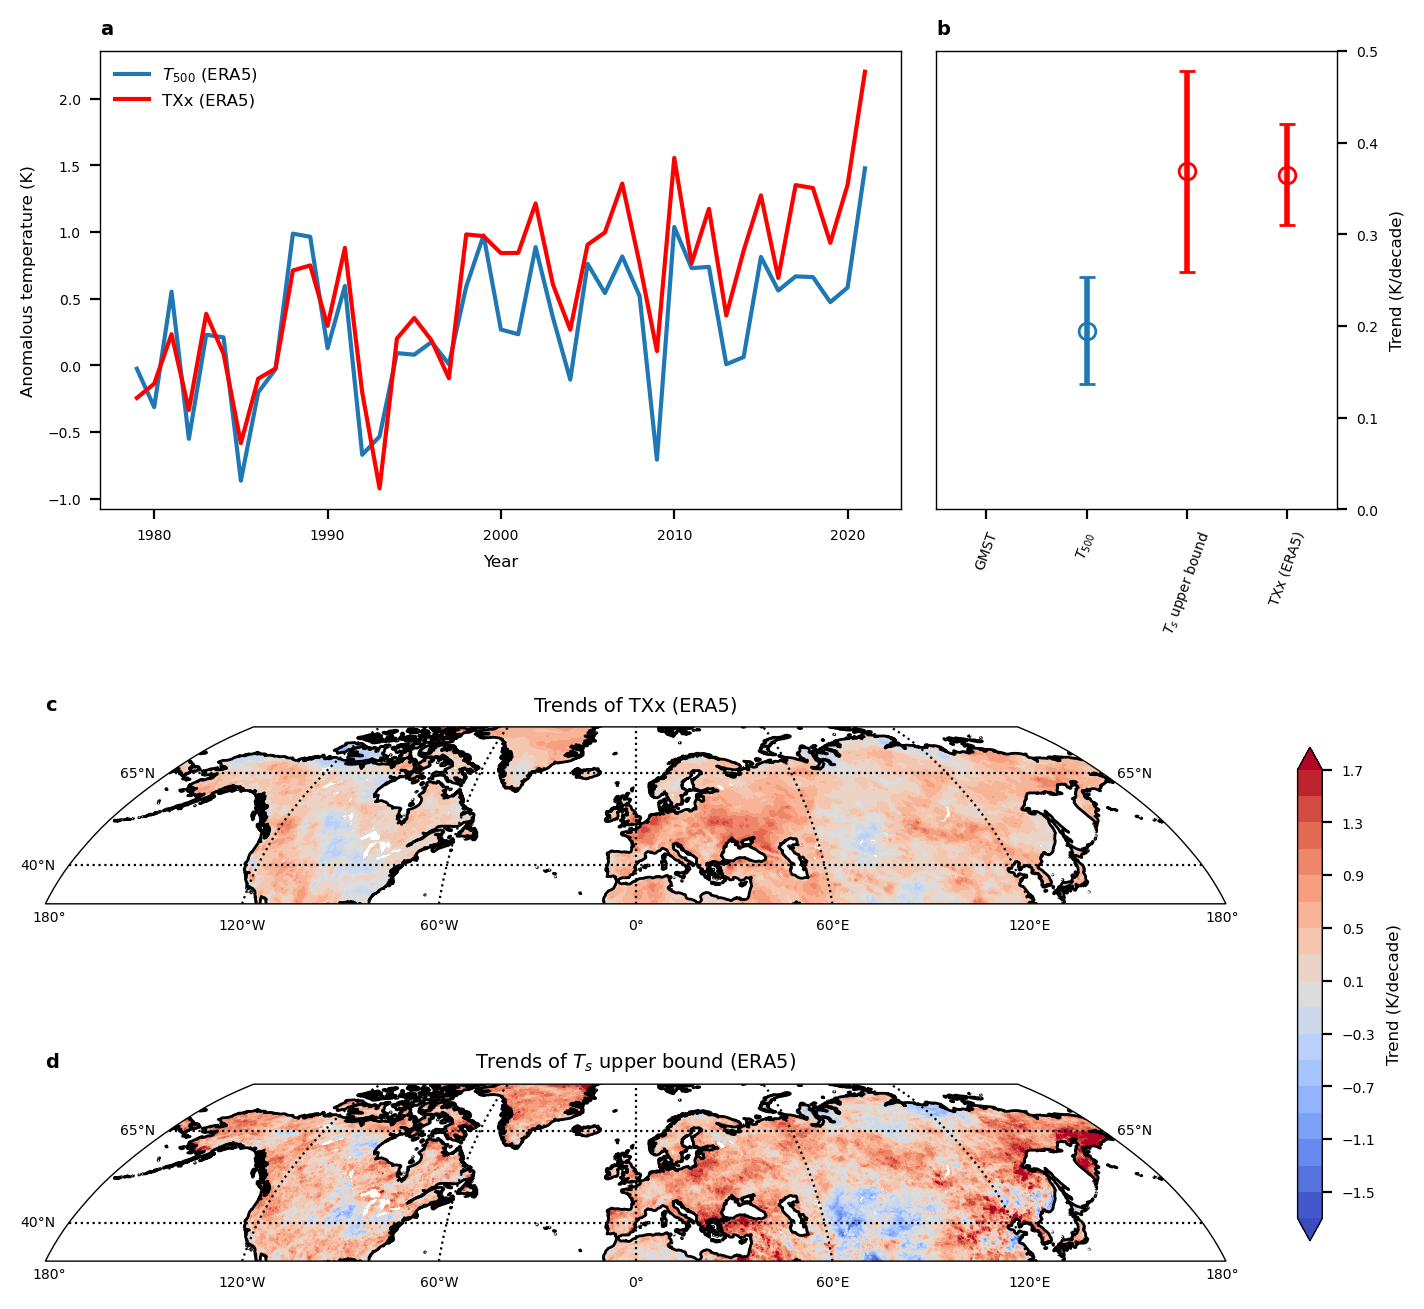

CPU times: user 54 s, sys: 770 ms, total: 54.7 s
Wall time: 56.6 s


In [120]:
%%time
fig = plt.figure(constrained_layout=True,figsize=(7.,6.5))
subfigs = fig.subfigures(2,1,height_ratios=(1,1.), hspace=0.05)

subfig0 = subfigs[0].subplots(1,2, gridspec_kw = {'width_ratios': (2,1), 'wspace': 0.05})
subfig1 = subfigs[1].subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0.15})
ax0 = subfig0[0]
ax1 = subfig0[1]
ax3 = subfig1[0]
ax4 = subfig1[1]
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")


# ax0.plot(np.arange(1979,2022), gmst[1979-1850:2022-1850]-gmst[1979-1850:1979-1850+10].mean(), c='grey', label='GMST (HadCRUT5)')
ax0.plot(years, t500_of_TXx_mean-t500_of_TXx_mean[0:10].mean(), c='C0', label='$T_{\mathrm{500}}$ (ERA5)')
ax0.plot(years, TXx_mean-TXx_mean[0:10].mean(), c='r', label='TXx (ERA5)')
# ax0.plot(np.arange(1979,2019), TXx_ex-TXx_ex[0:10].mean(), c='r', ls='--', label='TXx (HadEX3)')
ax0.legend(frameon=0)
ax0.set_xlabel('Year')
ax0.set_ylabel('Anomalous temperature (K)')
ax0.set_title('a', weight='bold', loc='left')

# obj = sts.linregress(np.arange(1979,2022), gmst.sel(time=slice('1979','2021')))
# slope_gmst = obj.slope
# std_gmst = obj.stderr
# ax1.errorbar(-1, obj.slope*10, yerr=obj.stderr*10, marker='o', mfc='None', capsize=3, color='grey', lw=2)
obj = sts.linregress(years, t500_of_TXx_mean.sel(time=slice('1979','2021')))
ax1.errorbar(0, obj.slope*10, yerr=obj.stderr*10, marker='o', mfc='None', capsize=3, color='C0', lw=2)
# ax1.text(-0.05, 0.1, "{:.1f}".format(obj.slope/slope_gmst))
ax1.errorbar(1, TXx_trend_proj*10, yerr=TXx_trend_proj_std*10, marker='o', mfc='None', capsize=3, color='r', lw=2)
# ax1.text(0.95, 0.22, "{:.1f}".format(TXx_trend_proj.values/slope_gmst))
obj = sts.linregress(years, TXx_mean.sel(time=slice('1979','2021')))
ax1.errorbar(2,obj.slope*10, yerr=obj.stderr*10, marker='o', mfc='None', capsize=3, color='r', lw=2)
# ax1.text(1.95, 0.26, "{:.1f}".format(obj.slope/slope_gmst))
ax1.set_xlim(-1.5,2.5)
ax1.set_xticks([-1, 0,1,2])
ax1.set_xticklabels(['GMST', '$T_{\mathrm{500}}$','$T_s$ upper bound','TXx (ERA5)'],rotation=70)
ax1.set_ylabel('Trend (K/decade)')
ax1.set_title('b', weight='bold', loc='left')
ax1.set_ylim([0, 0.5])


ax3.coastlines(color='k', linewidth=1)
ax3.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
ax3.set_title('c', weight='bold', loc='left')
gl = ax3.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60),
                  ylocs=np.arange(40, 70, 25), linestyle=':',
                  color='k', alpha=1, draw_labels=True)
gl.right_labels =0
gl.top_labels=0
ax3.set_title('Trends of TXx (ERA5)')
data, lon = add_cyclic_point(reg_TXx.slope*10, coord=reg_TXx.longitude.values, axis=1)
im = ax3.contourf(lon, reg_TXx.latitude.values, data, transform=ccrs.PlateCarree(),levels=np.arange(-1.7, 1.71, 0.2), extend='both', cmap='coolwarm')
if include_hatch:
    hatch_insignificant_regions(ax3, reg_TXx.p_value)

ax4.coastlines(color='k', linewidth=1)
ax4.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
ax4.set_title('d', weight='bold', loc='left')
gl = ax4.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60),
                  ylocs=np.arange(40, 70, 25), linestyle=':',
                  color='k', alpha=1, draw_labels=True)
gl.right_labels =0
gl.top_labels=0
data, lon = add_cyclic_point(reg_TXx_proj.slope*10, coord=reg_TXx_proj.longitude.values, axis=1)
im = ax4.contourf(lon, reg_TXx_proj.latitude.values, data, transform=ccrs.PlateCarree(),levels=np.arange(-1.7, 1.71, 0.2), extend='both', cmap='coolwarm')



ax4.set_title('Trends of $T_s$ upper bound (ERA5)')
subfigs[1].colorbar(shrink=0.8, ax=subfig1, label='Trend (K/decade)', mappable=im)
plt.show()
savefig(fig)

## Specific Humidity Trends
This compares the specific humidity trends I compute from ERA5 data with that shown by Fig S6 in Zhang 2023.

In [15]:
d2m = xr.open_dataset(f'./processed/daily_{t2m_av_use}/d2m_of_t2m_max.nc').d2m  # dew temperature in K
sp = xr.open_dataset(f'./processed/daily_{t2m_av_use}/sp_of_t2m_max.nc').sp     # surface pressure in Pa
q2m = sphum_from_dew(d2m, sp)                                                   # 2m specific humidity in kg/kg
# q2m = ds_year_to_time(q2m)

q2m_annual_mean = xr.open_dataset(f'./processed/q2m_annual_mean.nc').q2m
q2m_annual_mean = ds_year_to_time(q2m_annual_mean)

In [23]:
# We plot same thing for q2m on TXx days and in annual mean (am). Record info here
q2m_plot_info = {'TXx': {'title': 'Trend of 2-m specific humidity on TXx days'},
                 'am': {'title': 'Trend of annual mean 2-m specific humidity'}}

q2m_plot_info['TXx']['mean'] = (ds_year_to_time(q2m)*land).sel(latitude=slice(lat_max,lat_min)).weighted(weights).mean(['latitude','longitude'])
q2m_plot_info['TXx']['reg'] = xr_linregress(time.sel(time=slice(str(years[0]), str(years[-1]))),
                        (ds_year_to_time(q2m)*land).sel(time=slice(str(years[0]), str(years[-1])))).compute() # Linear trend of TXx for each location over land

q2m_plot_info['am']['mean'] = (q2m_annual_mean*land).sel(latitude=slice(lat_max,lat_min)).weighted(weights).mean(['latitude','longitude'])
q2m_plot_info['am']['reg'] = xr_linregress(time.sel(time=slice(str(years[0]), str(years[-1]))),
                        (q2m_annual_mean*land).sel(time=slice(str(years[0]), str(years[-1])))).compute() # Linear trend of TXx for each location over land

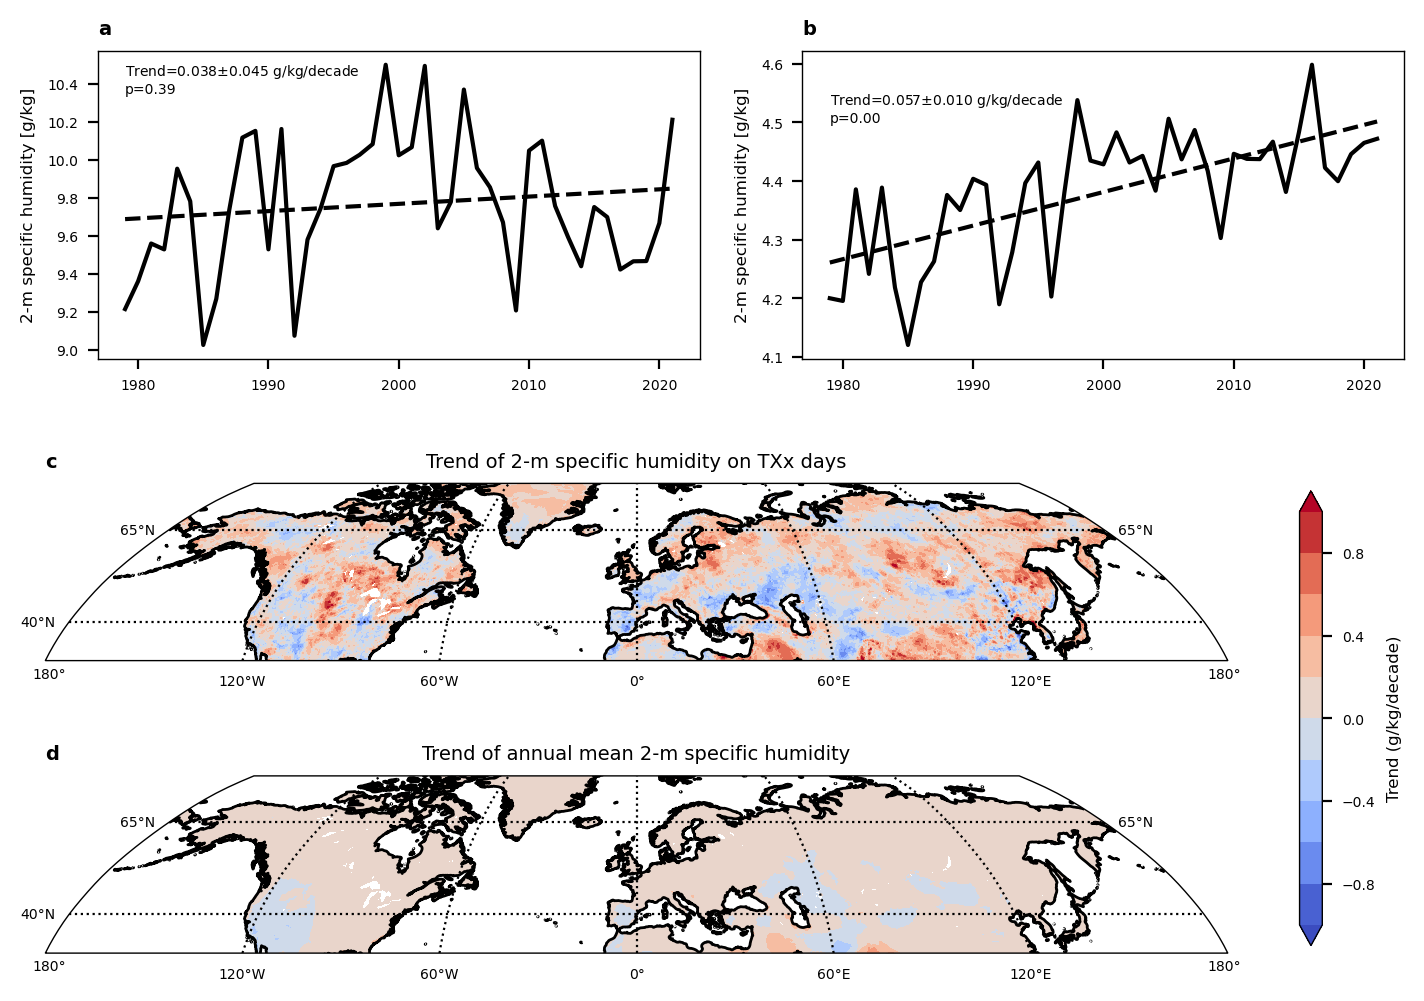

CPU times: user 27 s, sys: 312 ms, total: 27.4 s
Wall time: 27.6 s


In [121]:
%%time
fig = plt.figure(constrained_layout=True,figsize=(7.,5))
subfigs = fig.subfigures(2,1,height_ratios=(1,1.5), hspace=0.05)

subfig0 = subfigs[0].subplots(1,2, gridspec_kw = {'width_ratios': (1,1), 'wspace': 0.05})
subfig1 = subfigs[1].subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
q2m_plot_info['TXx']['ax'] = [subfig0[0], subfig1[0]]
q2m_plot_info['am']['ax'] = [subfig0[1], subfig1[1]]

q2m_plot_info['TXx']['ax'][1].yaxis.tick_right()
q2m_plot_info['TXx']['ax'][1].yaxis.set_label_position("right")

for key in q2m_plot_info.keys():
    q2m_plot_info[key]['ax'][0].plot(years, q2m_plot_info[key]['mean']*1000, c='k')
    obj = sts.linregress(years, q2m_plot_info[key]['mean'])
    q2m_plot_info[key]['ax'][0].plot(years, (obj.intercept + obj.slope * years) * 1000, color='k', linestyle='--')
    q2m_plot_info[key]['ax'][0].text(1979, 10.35 if key=='TXx' else 4.5,
                                     f'Trend={obj.slope*1000*10:.3f}$\pm${obj.stderr*1000*10:.3f} g/kg/decade\np={obj.pvalue:.2f}')
    # q2m_plot_info[key]['ax'][0].set_xlabel('Year')
    q2m_plot_info[key]['ax'][0].set_ylabel('2-m specific humidity [g/kg]')
    q2m_plot_info[key]['ax'][0].set_title('a' if key=='TXx' else 'b', weight='bold', loc='left')


    q2m_plot_info[key]['ax'][1].coastlines(color='k', linewidth=1)
    q2m_plot_info[key]['ax'][1].set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
    q2m_plot_info[key]['ax'][1].set_title('c' if key=='TXx' else 'd', weight='bold', loc='left')
    gl = q2m_plot_info[key]['ax'][1].gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60),
                      ylocs=np.arange(40, 70, 25), linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    q2m_plot_info[key]['ax'][1].set_title(q2m_plot_info[key]['title'])
    data, lon = add_cyclic_point(q2m_plot_info[key]['reg'].slope*1000*10, coord=q2m_plot_info[key]['reg'].longitude.values, axis=1)
    im = q2m_plot_info[key]['ax'][1].contourf(lon, q2m_plot_info[key]['reg'].latitude.values, data, transform=ccrs.PlateCarree(),
                                              levels=np.arange(-1, 1.1, 0.2), extend='both', cmap='coolwarm')

    # Hatch regions that did not pass significance test
    if include_hatch:
        hatch_insignificant_regions(q2m_plot_info[key]['ax'][1], q2m_plot_info[key]['reg'].p_value)

subfigs[1].colorbar(shrink=0.8, ax=subfig1, label='Trend (g/kg/decade)', mappable=im)
plt.show()
# savefig(fig)

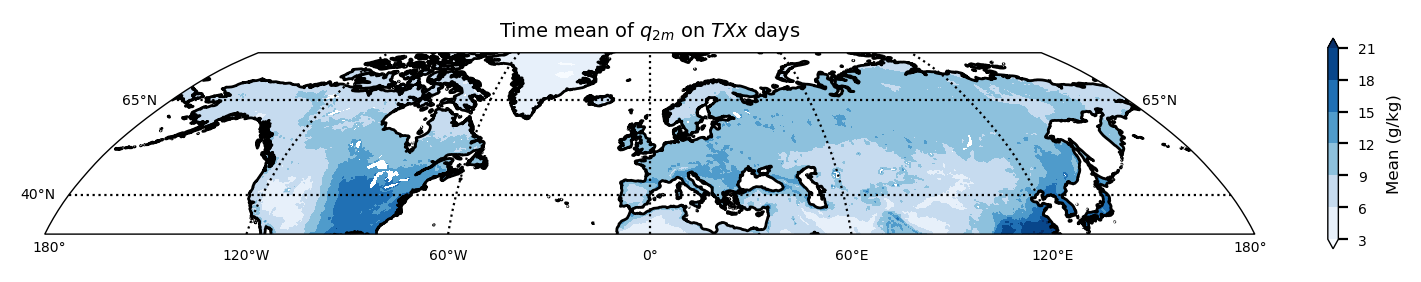

In [106]:
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
ax.coastlines(color='k', linewidth=1)
ax.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
gl = ax.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60),
                  ylocs=np.arange(40, 70, 25), linestyle=':',
                  color='k', alpha=1, draw_labels=True)
gl.right_labels=0
gl.top_labels=0

data, lon = add_cyclic_point(q2m.mean(dim='year') * land * 1000, coord=q2m.longitude.values, axis=1)
im = ax.contourf(lon, q2m.latitude.values, data, transform=ccrs.PlateCarree(),
                                          levels=np.arange(3, 24, 3), extend='both', cmap='Blues')
fig.colorbar(shrink=0.8, ax=ax, label='Mean (g/kg)', mappable=im)
ax.set_title('Time mean of $q_{2m}$ on $TXx$ days')
plt.show()
# savefig(fig)

In [107]:
t500_reg = xr_linregress(time.sel(time=slice(str(years[0]), str(years[-1]))),
                        (ds_year_to_time(t500)*land).sel(time=slice(str(years[0]), str(years[-1])))).compute()

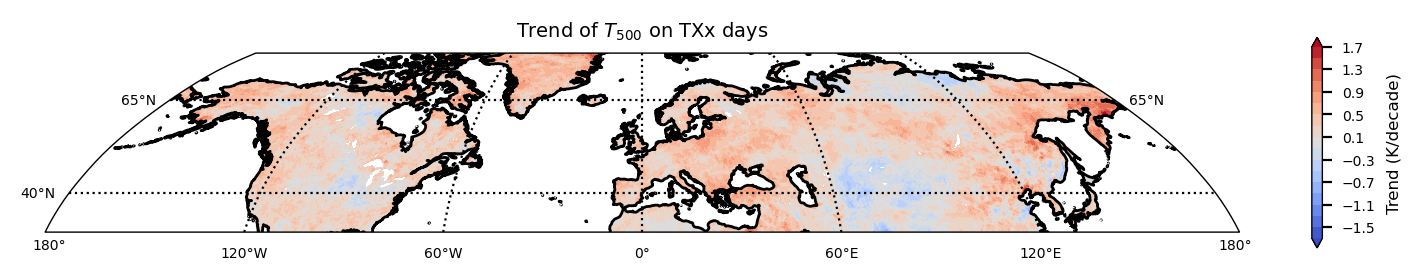

In [122]:
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
ax.coastlines(color='k', linewidth=1)
ax.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
gl = ax.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60),
                  ylocs=np.arange(40, 70, 25), linestyle=':',
                  color='k', alpha=1, draw_labels=True)
gl.right_labels=0
gl.top_labels=0

data, lon = add_cyclic_point(t500_reg.slope*10, coord=t500.longitude.values, axis=1)
im = ax.contourf(lon, t500.latitude.values, data, transform=ccrs.PlateCarree(),
                 levels=np.arange(-1.7, 1.71, 0.2), extend='both', cmap='coolwarm')
if include_hatch:
    hatch_insignificant_regions(ax, t500_reg.p_value)
fig.colorbar(shrink=0.8, ax=ax, label='Trend (K/decade)', mappable=im)
ax.set_title('Trend of $T_{500}$ on TXx days')
plt.show()
# savefig(fig)

## My Theory
### Height
#### My Theory
In my theory, the geopotential height difference between free troposphere and surface is expressed in terms of surface temperature, $T_s$, free tropospheric temperature, $T_{500}$ and surface pressure $p_s$.

In my work up until now, I have been considering $\sigma$ levels so $p_s/p_{FT}$ has been the same everywhere. Or equally, I have been considering the same location over different percentiles, where again $p_s/p_{FT}$ does not change much.

But here, I am considering the same percentile at different spatial locations, thus the variation of $p_s$ is vital and cannot be neglected.

#### Zhang 2023
In the Zhang 2023 formulation, $z_{500}$ is expressed in terms of $T_{FT}$ only, and then $z_s$ is required as well to link $h_{FT}^*$ to $h_s$. Below we see that this approximation is less good compared to my equation, but it is still very reasonable.

This has the advantage of being in terms of $z_s$ rather than $p_s$; and that $z_s$ does not vary across the percentile distribution or with time, whereas $p_s$ does. So for considering spatial variation, it makes sense to do this formulation.

I think it will just end up with a $\Delta z_s$ term. This probably makes sense, as the larger $z_s$, the closer $p_s$ is to 500hPa, and so the closer $T_s$ will be to $T_{500}$. In the Tibetan Plateau, I think $p_s$ is actually lower than 500hPa.

In [14]:
z500 = xr.open_dataset(f'./processed/daily_{t2m_av_use}/z500_of_t2m_max.nc').z500.squeeze()/g  # divide by g to convert to m
z2m = xr.open_dataset(f'../invariants/z1979.nc').z/g + 2       # add 2 as 2m geopotential height

In [26]:
def get_z_theory(temp_surf, temp_ft, p_surf, p_ft=500*100, taylor=True):
    # Returns z500 - z2m
    R_mod = R * np.log(p_surf / p_ft)/2
    if taylor:
        return R_mod/g * (temp_surf + temp_ft)
    else:
        return (temp_surf - temp_ft) * 2 * R_mod / g / np.log(temp_surf / temp_ft)

def get_z_theory_zhang(temp_ft, z2m=z2m):
    # Returns z500 - z2m
    return z500_mean/t500_mean * temp_ft / g - z2m

In [27]:
year_plot = 1979
z_diff_plot = {'simulated': (z500-z2m).sel(year=year_plot),
               'zhang': get_z_theory_zhang(t500.sel(year=year_plot)),
               'theory': get_z_theory(t2m_max.sel(year=year_plot), t500.sel(year=year_plot), sp.sel(year=year_plot)),
               'theory_const_sp': get_z_theory(t2m_max.sel(year=year_plot), t500.sel(year=year_plot), 1000*100)}

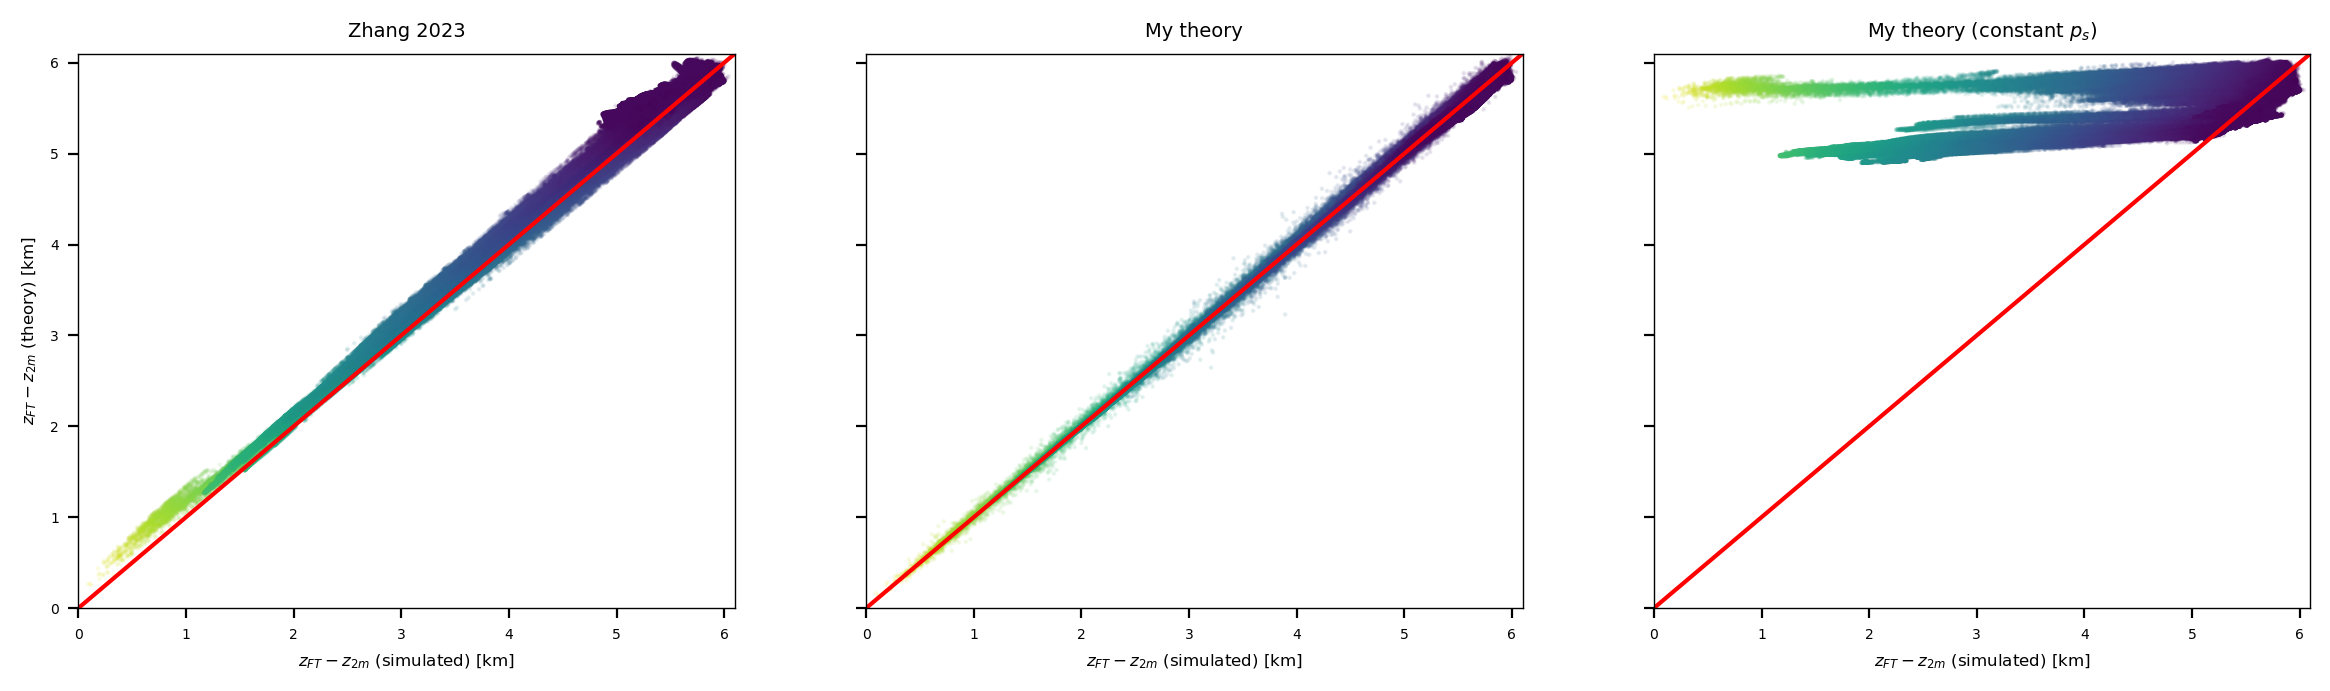

In [125]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
fig_resize(fig, 3*im_sz*width['one_col'])
ax[0].scatter(z_diff_plot['simulated']/1000, z_diff_plot['zhang']/1000,
              alpha=0.1, c=z2m/1000, cmap='viridis', s=0.5)
ax[1].scatter(z_diff_plot['simulated']/1000, z_diff_plot['theory']/1000,
              alpha=0.1, c=z2m/1000, cmap='viridis', s=0.5)
ax[2].scatter(z_diff_plot['simulated']/1000, z_diff_plot['theory_const_sp']/1000,
              alpha=0.1, c=z2m/1000, cmap='viridis', s=0.5)
ax_lim = [0, 6.1]
for ax_use in ax:
    ax_use.set_xlabel('$z_{FT}-z_{2m}$ (simulated) [km]')
    ax_use.plot(ax_lim, ax_lim, color='r')
ax[0].set_ylim(ax_lim)
ax[0].set_xlim(ax_lim)
ax[0].set_ylabel('$z_{FT}-z_{2m}$ (theory) [km]')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
ax[2].set_title('My theory (constant $p_s$)')
plt.show()
# plt.close()

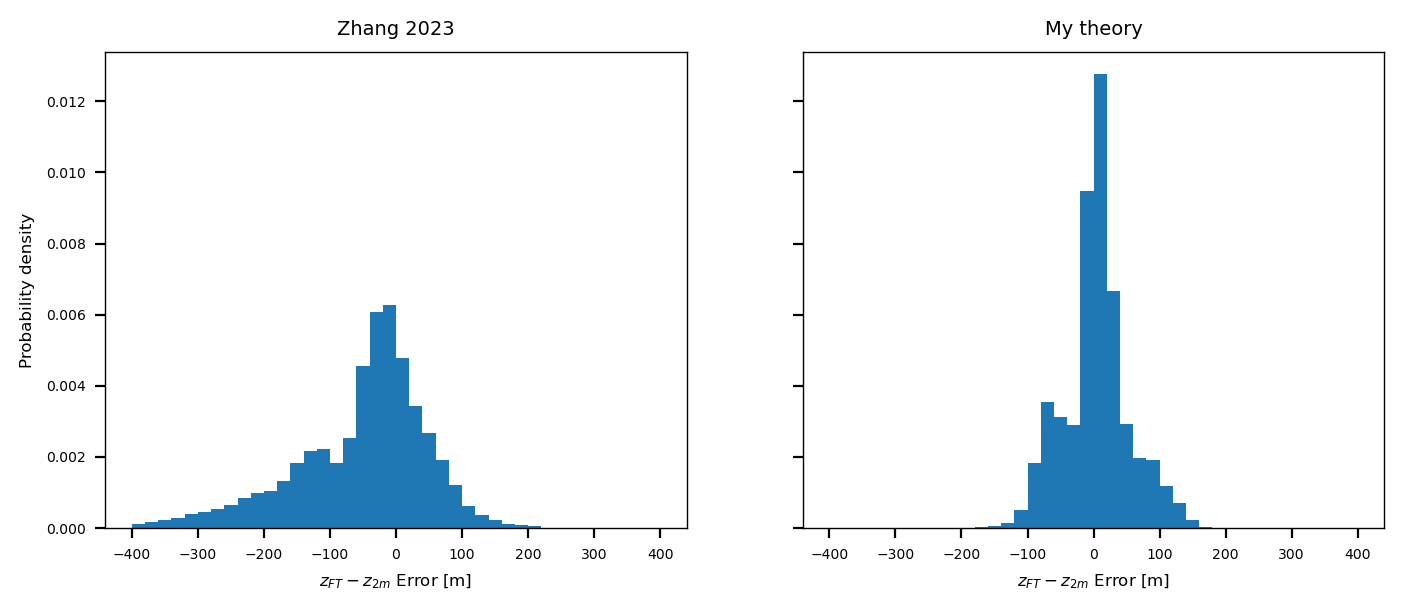

In [29]:
hist_bins = np.linspace(-400, 400, 41)
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
ax[0].hist((z_diff_plot['simulated']- z_diff_plot['zhang']).to_numpy().flatten(), bins=hist_bins, density=True)
ax[1].hist((z_diff_plot['simulated']- z_diff_plot['theory']).to_numpy().flatten(), bins=hist_bins, density=True)
# ax[1].hist((z_diff['simulated'][i]-z_diff['theory'][i]).to_numpy().flatten(), bins=hist_bins, density=True, alpha=0.5 if i==1 else 1)
ax[0].set_xlabel('$z_{FT}-z_{2m}}$ Error [m]')
ax[1].set_xlabel('$z_{FT}-z_{2m}$ Error [m]')
ax[0].set_ylabel('Probability density')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
plt.show()
# plt.close()

In [26]:
mse_lapse = moist_static_energy(t2m_max, q2m, z2m) - moist_static_energy(t500, sphum_sat(t500, 500*100), z500)
mse_lapse = mse_lapse.drop(['time', 'number'])
mse_lapse_mean = (mse_lapse*land).sel(latitude=slice(lat_max,lat_min)).weighted(weights).mean(['latitude','longitude'])
mse_lapse_reg = xr_linregress(time.sel(time=slice(str(years[0]), str(years[-1]))),
                              (ds_year_to_time(mse_lapse)*land).sel(time=slice(str(years[0]), str(years[-1])))).compute() # Linear trend of TXx for each location over land

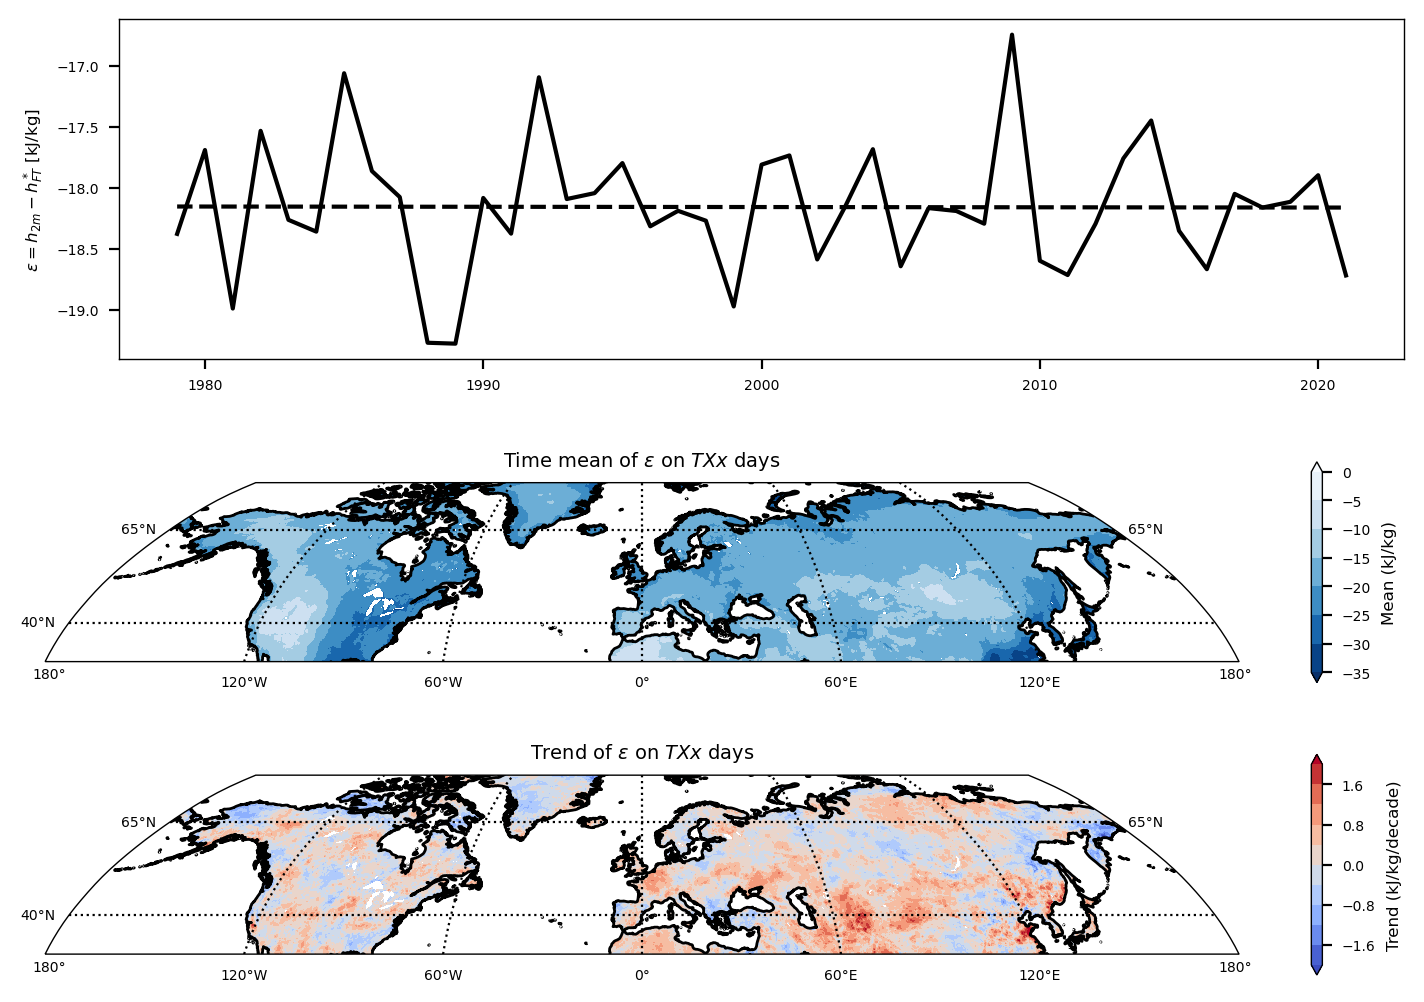

In [34]:
fig = plt.figure(constrained_layout=True,figsize=(7.,5))
subfigs = fig.subfigures(2,1,height_ratios=(1,1.5), hspace=0.05)

subfig0 = subfigs[0].subplots(1,1)
subfig1 = subfigs[1].subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
# q2m_plot_info['TXx']['ax'] = [subfig0[0], subfig1[0]]
# q2m_plot_info['am']['ax'] = [subfig0[1], subfig1[1]]
#
# q2m_plot_info['TXx']['ax'][1].yaxis.tick_right()
# q2m_plot_info['TXx']['ax'][1].yaxis.set_label_position("right")
subfig0.plot(years, mse_lapse_mean, c='k')
obj = sts.linregress(years, mse_lapse_mean)
subfig0.plot(years, (obj.intercept + obj.slope * years), color='k', linestyle='--')
subfig0.text(1979, 7.2, f'Trend={obj.slope*1000*10:.3f}$\pm${obj.stderr*1000*10:.3f} J/kg/decade\np={obj.pvalue:.2f}')
subfig0.set_ylabel('$\epsilon=h_{2m} - h_{FT}^*$ [kJ/kg]')

# Setup the spatial plots
for ax_use in subfig1:
    ax_use.coastlines(color='k', linewidth=1)
    ax_use.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
    gl = ax_use.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60),
                      ylocs=np.arange(40, 70, 25), linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0

data, lon = add_cyclic_point(mse_lapse.mean(dim='year') * land, coord=mse_lapse.longitude.values, axis=1)
im = subfig1[0].contourf(lon, mse_lapse.latitude.values, data, transform=ccrs.PlateCarree(),
                                          levels=np.arange(-25, 26, 5), extend='both', cmap='coolwarm')
subfigs[1].colorbar(shrink=0.8, ax=subfig1[0], label='Mean (kJ/kg)', mappable=im)

data, lon = add_cyclic_point(mse_lapse_reg.slope*10, coord=mse_lapse.longitude.values, axis=1)
im = subfig1[1].contourf(lon, mse_lapse.latitude.values, data, transform=ccrs.PlateCarree(),
                                          levels=np.arange(-2, 2.2, 0.4), extend='both', cmap='coolwarm')
subfig1[0].set_title(f'Time mean of $\epsilon$ on $TXx$ days')
subfig1[1].set_title(f'Trend of $\epsilon$ on $TXx$ days')
if include_hatch:
    # Hatch regions that did not pass significance test
    hatch_insignificant_regions(subfig1[1], mse_lapse_reg.p_value)

subfigs[1].colorbar(shrink=0.8, ax=subfig1[1], label='Trend (kJ/kg/decade)', mappable=im)
plt.show()
# savefig(fig)

In [68]:
rh = q2m / sphum_sat(t2m_max, sp) * 100   # in units of %
rh_mean = (rh*land).sel(latitude=slice(lat_max,lat_min)).weighted(weights).mean(['latitude','longitude'])
rh_reg = xr_linregress(time.sel(time=slice(str(years[0]), str(years[-1]))),
                              (ds_year_to_time(rh)*land).sel(time=slice(str(years[0]), str(years[-1])))).compute() # Linear trend of TXx for each location over land

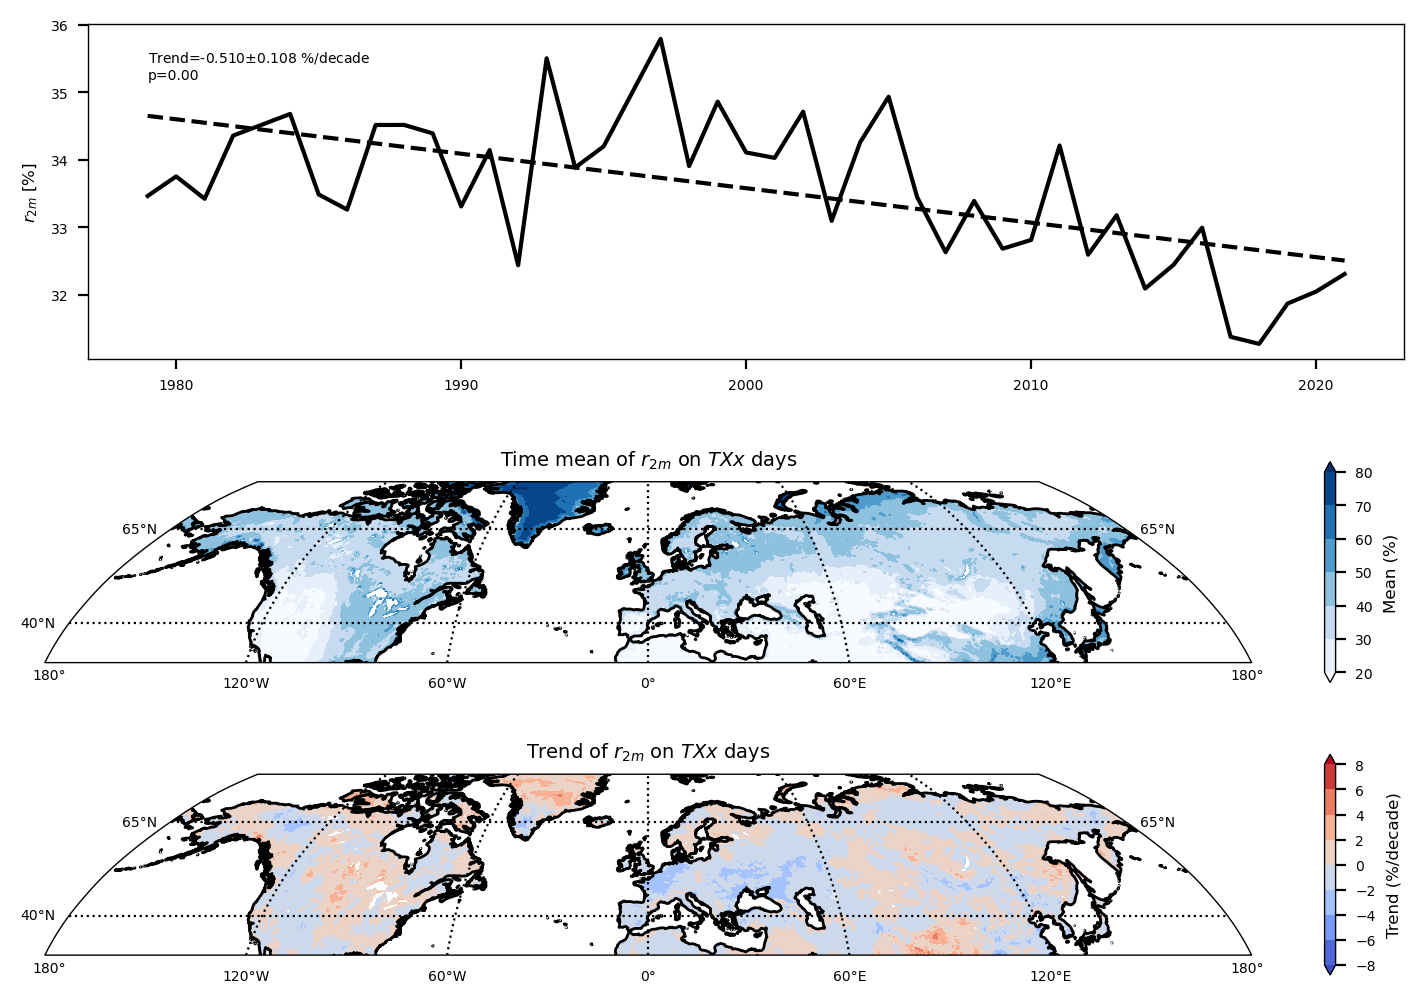

In [124]:
fig = plt.figure(constrained_layout=True,figsize=(7.,5))
subfigs = fig.subfigures(2,1,height_ratios=(1,1.5), hspace=0.05)

subfig0 = subfigs[0].subplots(1,1)
subfig1 = subfigs[1].subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
# q2m_plot_info['TXx']['ax'] = [subfig0[0], subfig1[0]]
# q2m_plot_info['am']['ax'] = [subfig0[1], subfig1[1]]
#
# q2m_plot_info['TXx']['ax'][1].yaxis.tick_right()
# q2m_plot_info['TXx']['ax'][1].yaxis.set_label_position("right")
subfig0.plot(years, rh_mean, c='k')
obj = sts.linregress(years, rh_mean)
subfig0.plot(years, (obj.intercept + obj.slope * years), color='k', linestyle='--')
subfig0.text(1979, 35.2, f'Trend={obj.slope*10:.3f}$\pm${obj.stderr*10:.3f} %/decade\np={obj.pvalue:.2f}')
subfig0.set_ylabel('$r_{2m}$ [%]')

# Setup the spatial plots
for ax_use in subfig1:
    ax_use.coastlines(color='k', linewidth=1)
    ax_use.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
    gl = ax_use.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60),
                      ylocs=np.arange(40, 70, 25), linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    # data, lon = add_cyclic_point(q2m_plot_info[key]['reg'].slope*1000*10, coord=q2m_plot_info[key]['reg'].longitude.values, axis=1)
data, lon = add_cyclic_point(rh.mean(dim='year') * land, coord=rh.longitude.values, axis=1)
im = subfig1[0].contourf(lon, rh.latitude.values, data, transform=ccrs.PlateCarree(),
                                          levels=np.arange(20, 90, 10), extend='both', cmap='Blues')
subfigs[1].colorbar(shrink=0.8, ax=subfig1[0], label='Mean (%)', mappable=im)
subfig1[0].set_title('Time mean of $r_{2m}$ on $TXx$ days')
#
data, lon = add_cyclic_point(rh_reg.slope*10, coord=rh.longitude.values, axis=1)
im = subfig1[1].contourf(lon, rh.latitude.values, data, transform=ccrs.PlateCarree(),
                                          levels=np.arange(-8, 10, 2), extend='both', cmap='coolwarm')
subfig1[1].set_title('Trend of $r_{2m}$ on $TXx$ days')
if include_hatch:
    # Hatch regions that did not pass significance test
    hatch_insignificant_regions(subfig1[1], rh_reg.p_value)

subfigs[1].colorbar(shrink=0.8, ax=subfig1[1], label='Trend (%/decade)', mappable=im)
plt.show()
# savefig(fig)

Text(0, 0.5, '$p_s$')

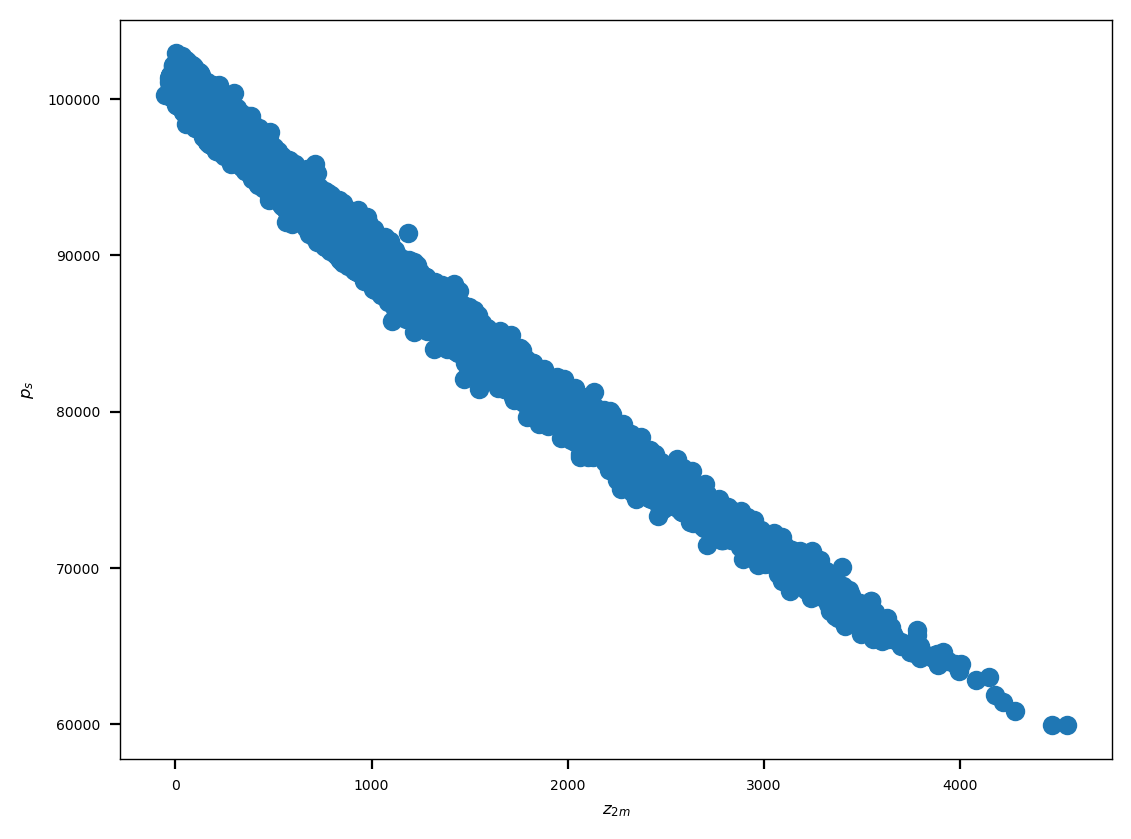

In [135]:
plt.scatter(z2m.sel(latitude=slice(65, 40))*land, sp.sel(latitude=slice(65, 40)).isel(year=-1)*land)
plt.xlabel('$z_{2m}$')
plt.ylabel('$p_s$')